In [ ]:
# default_exp gcp_helpers

# EUMETSAT and GCP 

The intention is to run a DAG using Google Cloud Composer that:  

1. Uses the EUMETSAT DownloadManager will check for available files over a time period.  
2. Compares with already downloaded files in a GCP bucket
3. Downloads any files not already downloaded, compressed using `pbzip2`

Run on europe-west4 (Netherlands) by preference.  

Our bucket and an example folder prefix is defined below.  

The data is stored in the format `gs://solar-pv-nowcasting-data/satellite/EUMETSAT/SEVIRI_RSS/native/<year>/<month>/<day>/<hour>/<minute>/` as per the existing files.

### Setup

In [80]:
#export
from google.cloud import storage
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Some GCP Helpers

First need a couple of helper functions to work with Google Cloud Platform.  
Ideally the principles will transfer easily to other cloud providers if necessary. 

In [3]:
#export 
def list_blobs_with_prefix(bucket_name, prefix, delimiter=None):
    """Lists all the blobs in the bucket that begin with the prefix.

    This can be used to list all blobs in a "folder", e.g. "public/".

    The delimiter argument can be used to restrict the results to only the
    "files" in the given "folder". Without the delimiter, the entire tree under
    the prefix is returned. For example, given these blobs:

        a/1.txt
        a/b/2.txt

    If you just specify prefix = 'a', you'll get back:

        a/1.txt
        a/b/2.txt

    However, if you specify prefix='a' and delimiter='/', you'll get back:

        a/1.txt

    Additionally, the same request will return blobs.prefixes populated with:

        a/b/
    """

    storage_client = storage.Client()

    # Note: Client.list_blobs requires at least package version 1.17.0.
    blobs = storage_client.list_blobs(bucket_name, prefix=prefix, delimiter=delimiter)

    names = []

    for blob in blobs:
        names.append(blob.name)
    return names


def blob_metadata(bucket_name, blob_name):
    """Prints out a blob's metadata."""
    # bucket_name = 'your-bucket-name'
    # blob_name = 'your-object-name'

    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.get_blob(blob_name)

    print("Blob: {}".format(blob.name))
    print("Bucket: {}".format(blob.bucket.name))
    print("Storage class: {}".format(blob.storage_class))
    print("ID: {}".format(blob.id))
    print("Size: {} bytes".format(blob.size))
    print("Updated: {}".format(blob.updated))
    print("Generation: {}".format(blob.generation))
    print("Metageneration: {}".format(blob.metageneration))
    print("Etag: {}".format(blob.etag))
    print("Owner: {}".format(blob.owner))
    print("Component count: {}".format(blob.component_count))
    print("Crc32c: {}".format(blob.crc32c))
    print("md5_hash: {}".format(blob.md5_hash))
    print("Cache-control: {}".format(blob.cache_control))
    print("Content-type: {}".format(blob.content_type))
    print("Content-disposition: {}".format(blob.content_disposition))
    print("Content-encoding: {}".format(blob.content_encoding))
    print("Content-language: {}".format(blob.content_language))
    print("Metadata: {}".format(blob.metadata))

## User input

In [8]:
BUCKET_NAME = "solar-pv-nowcasting-data"
PREFIX = "satellite/EUMETSAT/SEVIRI_RSS/native/"

In [9]:
blobs = list_blobs_with_prefix(BUCKET_NAME, prefix=PREFIX)

In [10]:
print(f'There are {len(blobs)} files')

There are 170669 files


Note that using the storage client to return blobs returns an iterable of blob metadata objects.  
From those we've extracted the names. We can go backwards from the names to interact with the blobs. 

In [27]:
df = pd.DataFrame(blobs, columns=['blobs'])
df = df[df['blobs'].str.endswith('.nat.bz2')] # only compressed data files
df['datetime'] = pd.to_datetime(df['blobs'].str.slice(start=37, stop=53), format="%Y/%m/%d/%H/%M")

In [63]:
months_in_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

In [76]:
blobs_by_month = df\
        .assign(year=lambda x: x['datetime'].dt.year)\
        .assign(month=lambda x: x['datetime'].dt.month_name())\
        .groupby(['month', 'year']).count()['blobs'].to_frame()\
        .reset_index()\
        .pivot(index='month', columns='year', values='blobs')\
        .reindex(months_in_order)

blobs_by_month

year,2018,2019
month,,
January,NaN,8556.0
February,NaN,7728.0
March,NaN,8545.0
April,NaN,8278.0
May,60.0,8384.0
June,8443.0,8280.0
July,15933.0,8826.0
August,8754.0,8922.0
September,8634.0,8552.0


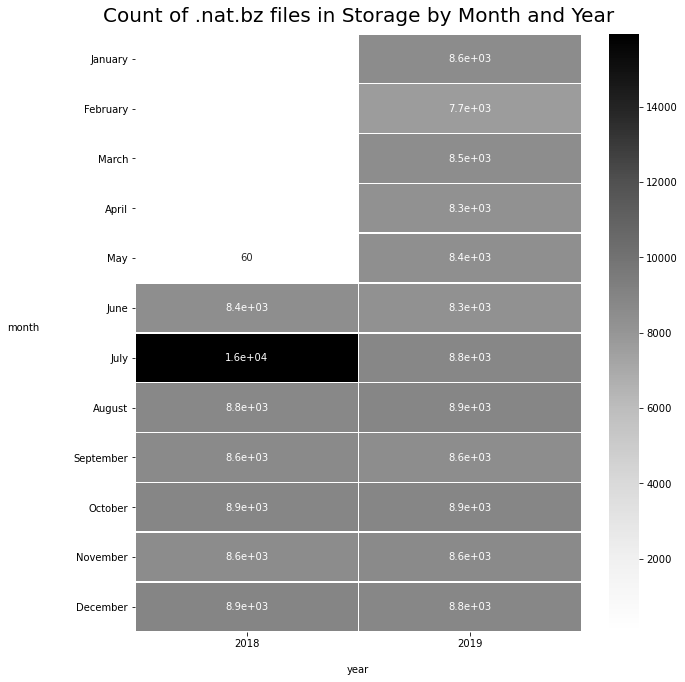

In [82]:
# credit: https://dfrieds.com/data-visualizations/visualize-historical-time-comparisons.html

figure, axes = plt.subplots(figsize=(10, 11))
sns.heatmap(blobs_by_month, annot=True, linewidths=.5, ax=axes, cmap="Greys")
axes.axes.set_title("Count of .nat.bz files in Storage by Month and Year", fontsize=20, y=1.01)
axes.axes.set_ylabel("month", labelpad=50, rotation=0)
axes.axes.set_xlabel("year", labelpad=16);
plt.yticks(rotation=0);